<a href="https://colab.research.google.com/github/VozSoldat/PCVK-Ganjil-2025/blob/main/Week7_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum Filter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from google.colab.patches import cv2_imshow
from PIL import Image as im

## Konvolusi tanpa library
1. citra masukan
2. kernel berupa matriks untuk memfilter citra
3. nilai stride/besarnya pergeseran setiap konvolusi
4. nilai pad yang akan ditambahkan pada citra

In [9]:
def convolution2d(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    output_image = np.zeros((output_height, output_width))

    # Perform the convolution
    for i in range(output_height):
        for j in range(output_width):
            # ROI
            roi = image[i:i + kernel_height, j:j + kernel_width]

            output_image[i, j] = np.sum(roi * kernel)

    return output_image

mandrill = cv2.imread('/content/drive/MyDrive/PCVK/mandrill.tiff')
if mandrill is not None:
    mandrill = cv2.cvtColor(mandrill, cv2.COLOR_BGR2GRAY)
else:
    print("Failed to load the image.")



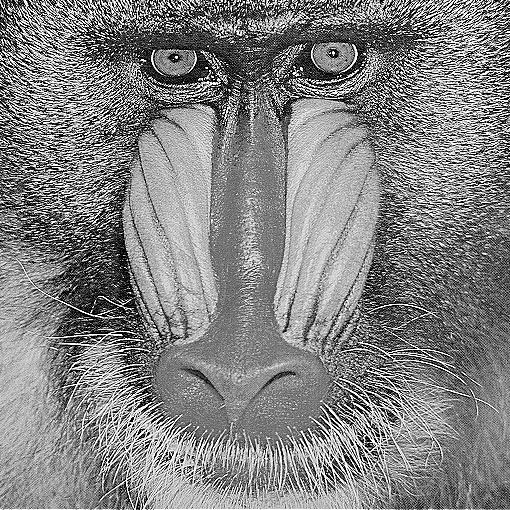

In [21]:
# sharpen
kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

sharpened_image = convolution2d(mandrill, kernel)

cv2_imshow(sharpened_image)

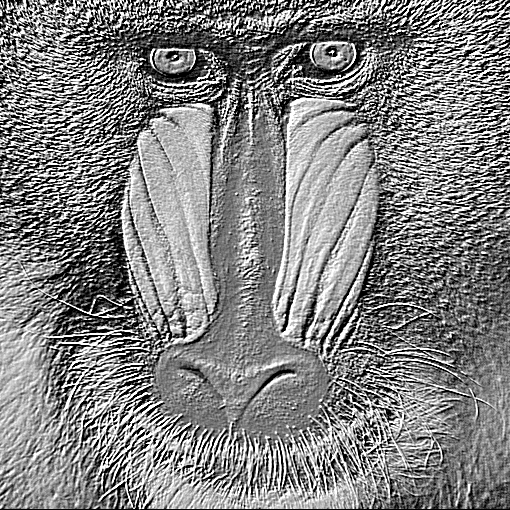

In [23]:
# emboss
kernel = np.array([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]
])

embossed_image = convolution2d(mandrill, kernel)

cv2_imshow(embossed_image)

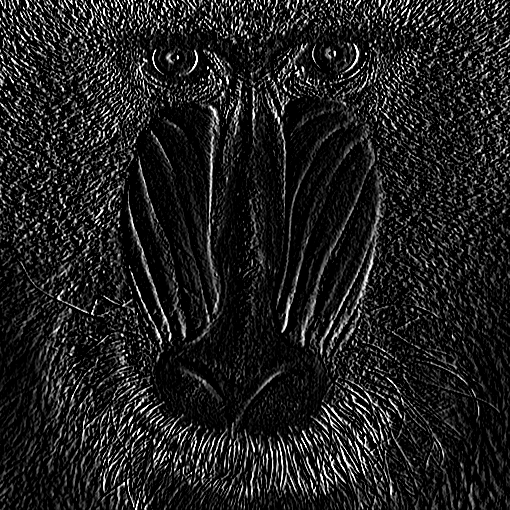

In [24]:
# left sobel edge detection
kernel = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])

left_sobel = convolution2d(mandrill, kernel)

cv2_imshow(left_sobel)

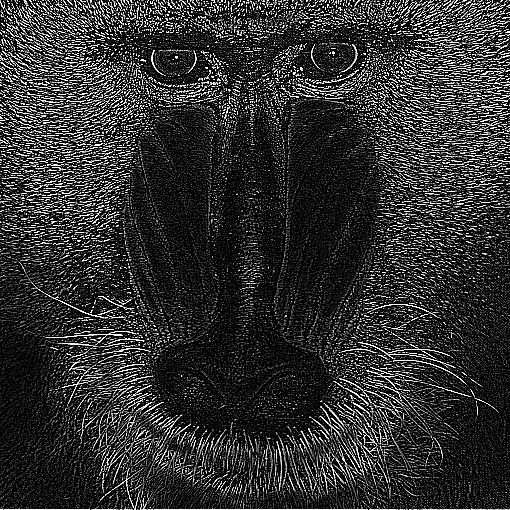

In [25]:
# canny edge detection
kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

canny_edge = convolution2d(mandrill, kernel)

cv2_imshow(canny_edge)

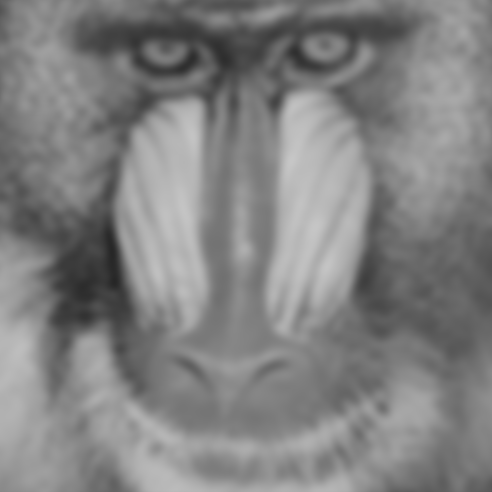

In [31]:
# gaussian blur

sigma=math.sqrt(21)
gaussian_kernel = cv2.getGaussianKernel(21, sigma)
gauss_kernel = gaussian_kernel @ gaussian_kernel.transpose()

gauss_image = convolution2d(mandrill, gauss_kernel)

cv2_imshow(gauss_image)

# Filter library dan filter modern

## Percobaan 1
Pada percobaan 1 ini, kita akan membuat Filter Gaussian, Sharpen, dan Canny menggunakanlibraryfilter2d dari OpenCV. Filter ini akan kita terapkan pada Image RGB. Pada bagian awal kode terdapat
fungsi show_side_by_side yang digunakan untuk menampilkan gambar secara berdampingan.

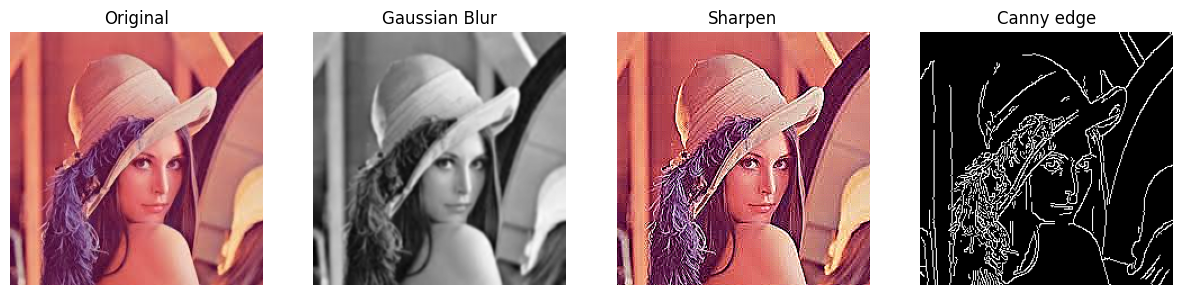

In [33]:
def show_side_by_side(images, titles, figsize=(15,5)):
  plt.figure(figsize=figsize)
  for i, (img, title) in enumerate(zip(images, titles)):
    if len(img.shape) == 2:
      plt.subplot(1, len(images), i+1)
      plt.imshow(img, cmap="gray")
    else:
      plt.subplot(1, len(images), i+1)
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
  plt.show()

img = cv2.imread('/content/drive/MyDrive/PCVK/lena.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(img_gray, (7,7), 1)
edges = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 100, 200)
sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
sharpen = cv2.filter2D(img, -1, sharpen_kernel)

show_side_by_side([img, blur, sharpen, edges], ["Original", "Gaussian Blur", "Sharpen", "Canny edge"])

## Percobaan 2

Pada percobaan 2 berikut ini akan dilakukan filtering modern dari Library OpenCV. Dua filter yangakan digunakan adalah Bilateral Filtering dan Guided Filter. Bilateral filtering adalah sebuahmetodepenyaringan non-linear yang banyak digunakan untuk menghaluskan citra sekaligus tetapmempertahankan ketajaman tepi. Berbeda dengan Gaussian blur biasa yang hanyamemperhitungkan jarak spasial antar piksel, bilateral filter juga mempertimbangkan perbedaanintensitas warna. Dengan cara ini, piksel-piksel yang letaknya dekat dan memiliki warnamiripdengan pusat jendela akan mendapat bobot lebih besar dalam perhitungan, sedangkanpiksel
dengan perbedaan warna kontras (misalnya di sisi tepi) akan tereduksi pengaruhnya. Akibatnya, citramenjadi lebih halus pada area datar, namun garis batas dan detail penting tetap terjaga. Meskipunmenghasilkan kualitas yang baik, bilateral filter tergolong lambat karena perhitungan bobot yangcukup kompleks. Dalam praktiknya, filter ini banyak dipakai untuk keperluan seperti perbaikankualitas foto, pengurangan noise, maupun sebagai dasar dari efek beauty filter untuk melembutkantekstur kulit tanpa mengaburkan kontur wajah.

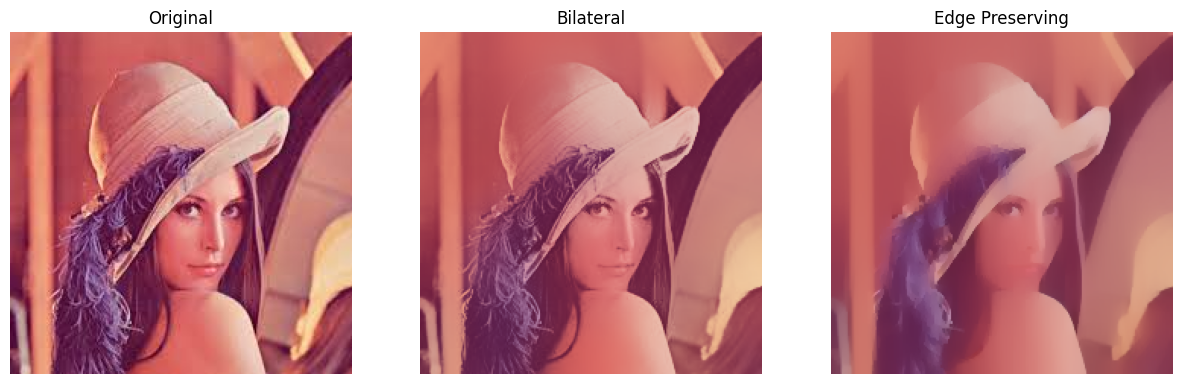

In [34]:
bilateral = cv2.bilateralFilter(img, 50, 100, 100)

edge_preserve = cv2.edgePreservingFilter(img, flags=1, sigma_s=100, sigma_r=0.9)

show_side_by_side([img, bilateral, edge_preserve], ["Original", "Bilateral", "Edge Preserving"])

## Percobaan 3

Percobaan kali ini akan mencoba melihat proses Filtering pada CNN (bagian Feature Map), lakukanrunning code beberapa kali dan perhatikan hasil outputnya. Apa yang dapat kamu simpulkandari
hasil keluaran tersebut.

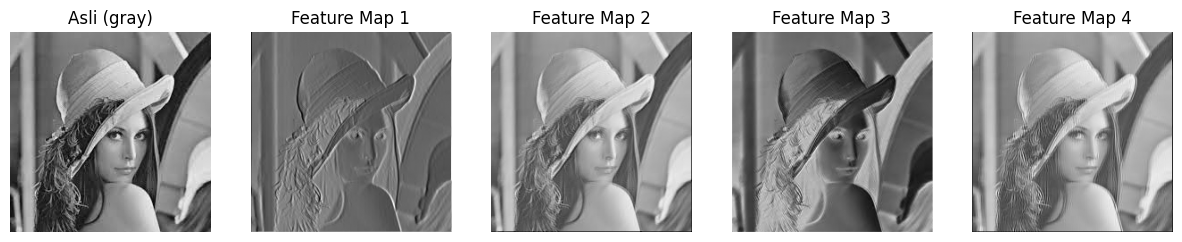

In [36]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    return self.conv1(x)

model = SimpleCNN()

img_tensor = torch.tensor(img_gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0

with torch.no_grad():
  features = model(img_tensor)

feature_maps = [features[0,i].numpy() for i in range(features.shape[1])]

show_side_by_side([img_gray] + feature_maps, ["Asli (gray)"] + [f"Feature Map {i+1}" for i in range(len(feature_maps))])

## Percobaan 4

Percobaan kali ini akan melakukan efek Beauty dan Vintage yang biasanya digunakan pada Aplikasi
popular saat ini. Filter yang digunakan merupakan kombinasi dari filter tradisional. Perlu diketahui
untuk filter aplikasi popular bisa jadi tidak menggunakan metode yang sama. Pada Aplikasi popularbisa jadi menggunakan model GenAI dengan data Training untuk memberikan hasil yang lebihakurat

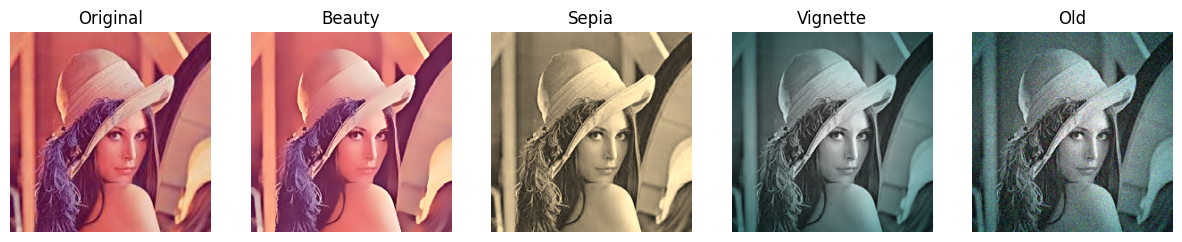

In [45]:
# 1. Beauty Filter
#Step 1: Smoothing kulit dengan bilateral filter
smooth =  cv2.bilateralFilter(img, d=15, sigmaColor=75, sigmaSpace=75)
#Step 2: Unsharp masking (pertajam mata/bibir)
gaussian =  cv2.GaussianBlur(smooth, (0,0), 3)
sharpened = cv2.addWeighted (smooth, 1.5, gaussian, -0.5, 0)
#Step 3: Brightness & contrast
alpha = 1.2 # contrast
beta = 15
# brightness
beauty = cv2.convertScaleAbs (sharpened, alpha-alpha, beta=beta)


#2. Old/Vintage Filter
#Step 1: Sepia tone
sepia_kernel = np.array(
    [[0.272, 0.534, 0.131],
     [0.349, 0.686, 0.168],
     [0.393, 0.769, 0.189]])
sepia = cv2.transform(img, sepia_kernel)
sepia = np.clip(sepia, 0, 255).astype(np.uint8)

#Step 2: Vignette
rows, cols = img.shape[:2]
kernel_x = cv2.getGaussianKernel (cols, cols*0.6)
kernel_y = cv2.getGaussianKernel (rows, rows*0.6)
kernel = kernel_y * kernel_x.T
mask = kernel / kernel.max()
vignette = np.copy(sepia)
for i in range(3):
  vignette[:,:,i] = vignette[:,:,1] * mask

#Step 3: Noise/Grain
noise = np.random.normal(0, 15, vignette.shape).astype(np.int16)
old_img = np.clip(vignette.astype(np.int16) + noise, 0, 255).astype (np.uint8)

show_side_by_side([img, beauty, sepia, vignette, old_img], ["Original", "Beauty", "Sepia", "Vignette", "Old"])

## Percobaan 5

Percobaan 5 akan menunjukkan pada anda filter anime / cartoon menggunakan kombinasi filtertradisional.

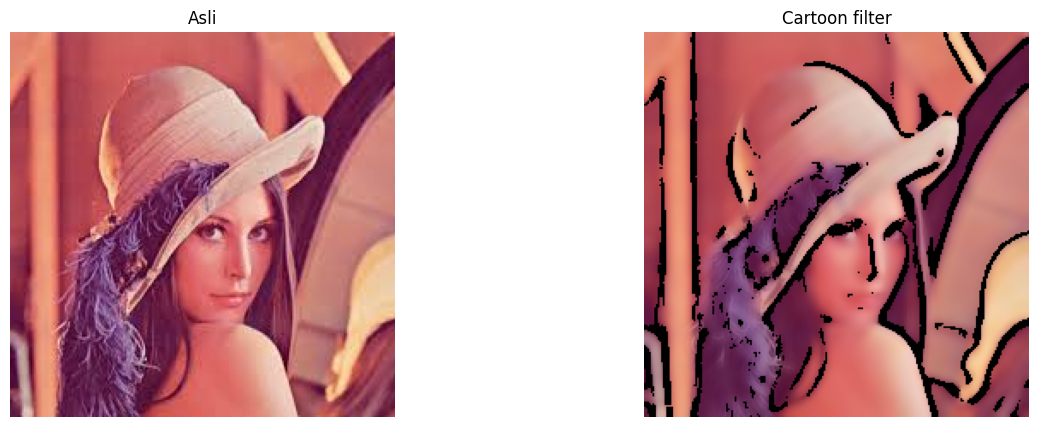

In [46]:
# filter anime

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray_blur = cv2.medianBlur(gray, 7)

edges = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)

color = cv2.bilateralFilter(img, d=9, sigmaColor=200, sigmaSpace=200)

cartoon = cv2.bitwise_and(color, color, mask=edges)

show_side_by_side([img, cartoon], ["Asli", "Cartoon filter"])

## Percobaan 6

Pada Percobaan 6 akan ditunjukkan contoh Filter Malam

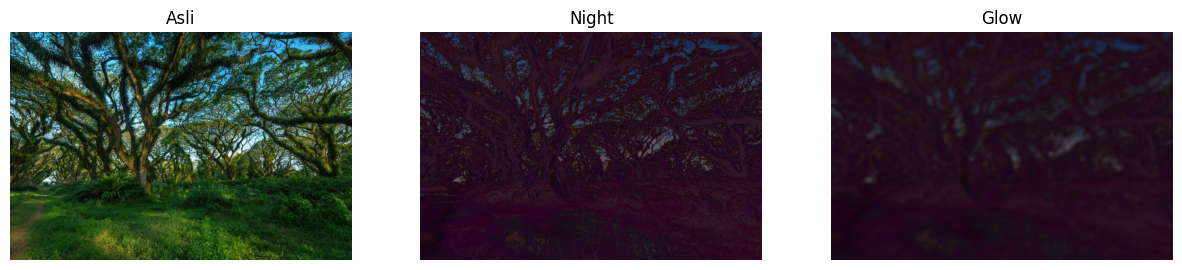

In [48]:
img = cv2.imread('/content/drive/MyDrive/PCVK/djawatan.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

night = cv2.convertScaleAbs(img, alpha=0.6 , beta=-40)

blue_tint = np.full_like(night, (50, 0, 100))
night = cv2.addWeighted(night, 0.8, blue_tint, 0.2, 0)

kernel = np.ones((15,15), np.float32) / 255
glow = cv2.filter2D(night, -1, kernel)

show_side_by_side([img, night, glow], ["Asli", "Night", "Glow"])

## Percobaan 7

Percobaan 7 menunjukkan Filter Pagi dan Pagi ditambahkan efek kabut.

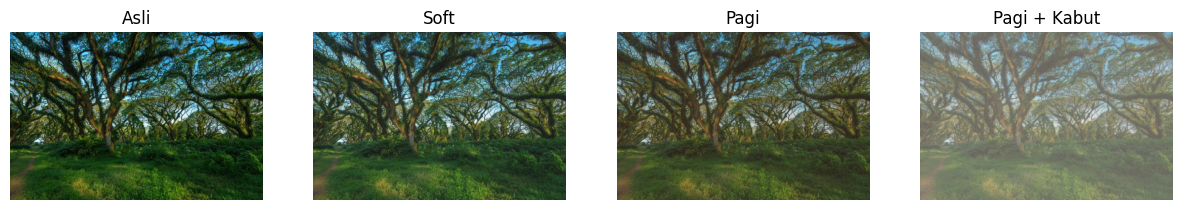

In [49]:
# step 1: kurangi kontras dan cerahkan

alpha = 0.9
beta = 20
soft = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

# step 2: tambahkan warm tone (kemerahan/oranye)

warm_tint = np.full_like(soft, (40, 70, 120))
pagi = cv2.addWeighted(soft, 0.8, warm_tint, 0.2, 0)

# step 3: tambahkan haze

kernel = cv2.getGaussianKernel(3,3)
kernel = kernel @ kernel.T

kabut = cv2.filter2D(pagi, -1, kernel)

white_layer = np.full_like(pagi, 255)
kabut = cv2.addWeighted(kabut, 0.7, white_layer, 0.3, 0)

show_side_by_side([img, soft, pagi, kabut], ["Asli", "Soft", "Pagi", "Pagi + Kabut"])